## Regression Week 5: LASSO Assignment 1

In this assignment, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:

* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second assignment, you will implement your own LASSO solver, using coordinate descent.

Load the sales dataset using Pandas:

In [1]:
import numpy as np
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('../week-3/kc_house_data.csv', dtype=dtype_dict)

Create new features by performing following transformation on inputs:

In [2]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

Using the entire house dataset, learn regression weights using an L1 penalty of `5e2`. Make sure to add `normalize=True` when creating the Lasso object. Refer to the following code snippet for the list of features.

**Note**. From here on, the list `all_features` refers to the list defined in this snippet.

In [3]:
from sklearn import linear_model  # using scikit-learn

all_features = ['bedrooms', 'bedrooms_square','bathrooms', 'sqft_living', 
                'sqft_living_sqrt','sqft_lot', 'sqft_lot_sqrt', 'floors', 
                'floors_square', 'waterfront', 'view', 'condition', 
                'grade', 'sqft_above', 'sqft_basement', 'yr_built', 
                'yr_renovated']

model_all = linear_model.Lasso(alpha=5e2, normalize=True) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

Lasso(alpha=500.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

***Quiz Question***: Which features have been chosen by LASSO, i.e. which features were assigned nonzero weights?

In [34]:
filter_1 = (model_all.coef_ != 0)
filter_1

np_all_features = np.array(all_features)
np_all_features[filter_1]

array(['sqft_living', 'view', 'grade'], dtype='<U16')

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets. Download the provided csv files containing training, validation and test sets.

In [5]:
testing = pd.read_csv('../week-3/wk3_kc_house_test_data.csv', dtype=dtype_dict)
training = pd.read_csv('../week-3/wk3_kc_house_train_data.csv', dtype=dtype_dict)
validation = pd.read_csv('../week-3/wk3_kc_house_valid_data.csv', dtype=dtype_dict)

Make sure to create the 4 features as we did in #1:

In [6]:
testing['sqft_living_sqrt'] = testing['sqft_living'].apply(sqrt)
testing['sqft_lot_sqrt'] = testing['sqft_lot'].apply(sqrt)
testing['bedrooms_square'] = testing['bedrooms']*testing['bedrooms']
testing['floors_square'] = testing['floors']*testing['floors']

training['sqft_living_sqrt'] = training['sqft_living'].apply(sqrt)
training['sqft_lot_sqrt'] = training['sqft_lot'].apply(sqrt)
training['bedrooms_square'] = training['bedrooms']*training['bedrooms']
training['floors_square'] = training['floors']*training['floors']

validation['sqft_living_sqrt'] = validation['sqft_living'].apply(sqrt)
validation['sqft_lot_sqrt'] = validation['sqft_lot'].apply(sqrt)
validation['bedrooms_square'] = validation['bedrooms']*validation['bedrooms']
validation['floors_square'] = validation['floors']*validation['floors']

Now for each l1_penalty in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)

* Learn a model on TRAINING data using the specified l1_penalty. Make sure to specify normalize=True in the constructor

* Compute the RSS on VALIDATION for the current model (print or save the RSS)

Report which L1 penalty produced the lower RSS on VALIDATION.

***Quiz Question***: Which was the best value for the l1_penalty, i.e. which value of l1_penalty produced the lowest RSS on VALIDATION data?

In [7]:
l1_penalty = np.logspace(1, 7, num=13)

def get_lowest_rss(l1_penalty, training, validation):
    for i in range(len(l1_penalty)):    
        model = linear_model.Lasso(alpha=l1_penalty[i], normalize=True)
        model.fit(X=training.loc[:, all_features], y=training['price'])
        pred_price = model.predict(validation.loc[:, all_features])
        rss = np.sum((pred_price - validation['price']) ** 2)
        
        if i == 0:
            lowest_rss = rss
            best_l1_penalty = l1_penalty[i]
            best_model = model
        
        if rss < lowest_rss:
            lowest_rss = rss
            best_l1_penalty = l1_penalty[i]
            best_model = model
    
    return (lowest_rss, best_l1_penalty, best_model)

lowest_rss, best_l1_penalty, best_model = get_lowest_rss(l1_penalty, training, validation)

print(lowest_rss)
print(best_l1_penalty)

398213327300134.94
10.0


Now that you have selected an L1 penalty, compute the RSS on TEST data for the model with the best L1 penalty.

***Quiz Question***: Using the best L1 penalty, how many nonzero weights do you have? Count the number of nonzero coefficients first, and add 1 if the intercept is also nonzero. A succinct way to do this is as below where `model` is an instance of `linear_model.Lasso`.

In [8]:
np.count_nonzero(best_model.coef_) + np.count_nonzero(best_model.intercept_)

15

In [9]:
best_model.coef_

array([-1.61445628e+04,  3.73245384e+02,  5.08412433e+04,  6.17853560e+02,
       -4.44113549e+04,  7.85623065e-01, -7.01194765e+02, -0.00000000e+00,
        5.01420046e+03,  6.19488752e+05,  3.80418557e+04,  2.49987718e+04,
        1.28716235e+05,  0.00000000e+00,  0.00000000e+00, -3.29383118e+03,
        1.00573209e+01])

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

You are going to implement a simple, two phase procedure to achieve this goal:

* Explore a large range of ‘l1_penalty’ values to find a narrow region of ‘l1_penalty’ values where models are likely to have the desired number of non-zero weights.
* Further explore the narrow region you found to find a good value for ‘l1_penalty’ that achieves the desired sparsity. Here, we will again use a validation set to choose the best value for ‘l1_penalty’.

Assign 7 to the variable ‘max_nonzeros’.

### Exploring large range of l1_penalty

For `l1_penalty` in `np.logspace(1, 4, num=20)`:

* Fit a regression model with a given `l1_penalty` on TRAIN data. Add `alpha=l1_penalty` and `normalize=True` to the parameter list.
* Extract the weights of the model and count the number of nonzeros. Take account of the intercept as we did in #8, adding 1 whenever the intercept is nonzero. Save the number of nonzeros to a list.

Out of this large range, we want to find the two ends of our desired narrow range of l1_penalty. At one end, we will have l1_penalty values that have too few non-zeros, and at the other end, we will have an l1_penalty that has too many non-zeros.

More formally, find:

* The largest l1_penalty that has more non-zeros than ‘max_nonzeros’ (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest l1_penalty that has fewer non-zeros than ‘max_nonzeros’ (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)Store this value in the variable `l1_penalty_max` (we will use it later)

Hint: there are many ways to do this, e.g.:

* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of l1_penalty and inspecting it to find the appropriate boundaries.

In [10]:
max_nonzeros = 7

l1_penalty = np.logspace(1, 4, num=20)
non_zeros = []

for i in range(len(l1_penalty)):
    model = linear_model.Lasso(alpha=l1_penalty[i], normalize=True)
    model.fit(X=training.loc[:, all_features], y=training['price'])
    non_zeros.append(np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_))
    
for j in range(1, len(non_zeros)-2):
    if non_zeros[j] > max_nonzeros and non_zeros[j+1] <= max_nonzeros:
        l1_penalty_min = l1_penalty[j]
        non_zero_cnt_left = non_zeros[j]
        j_left = j
    if non_zeros[j] < max_nonzeros and non_zeros[j-1] >= max_nonzeros:
        l1_penalty_max = l1_penalty[j]
        non_zero_cnt_right = non_zeros[j]
        j_right = j
        
print('left bound, l1_penalty_min: %.2f; non-zero count: %d; j: %d' % (l1_penalty_min, non_zero_cnt_left, j_left))
print('right bound, l1_penalty_max: %.2f; non-zero count: %d; j: %d' % (l1_penalty_max, non_zero_cnt_right, j_right))

left bound, l1_penalty_min: 127.43; non-zero count: 10; j: 7
right bound, l1_penalty_max: 263.67; non-zero count: 6; j: 9


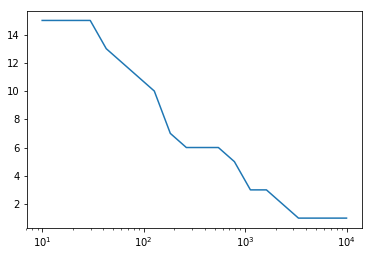

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(l1_penalty, non_zeros)
plt.xscale('log')

***Quiz Question***: What values did you find for l1_penalty_min and l1_penalty_max?

See above

### Exploring narrower range of l1_penalty

We now explore the region of l1_penalty we found: between `l1_penalty_min` and `l1_penalty_max`. We look for the L1 penalty in this range that produces exactly the right number of nonzeros and also minimizes RSS on the VALIDATION set.

For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:

* Fit a regression model with a given l1_penalty on TRAIN data. As before, use `alpha=l1_penalty` and `normalize=True`.
* Measure the RSS of the learned model on the VALIDATION set

Find the model that has the lowest RSS on the VALIDATION set and has sparsity equal to `max_nonzeros`. (Again, take account of the intercept when counting the number of nonzeros.)



In [17]:
l1_penalty = np.linspace(l1_penalty_min,l1_penalty_max,20)

def find_final_l1_penalty(l1_penalty, training, validation, all_features, max_nonzeros):
    non_zeros_final = []
    rss_validation = []
    lowest_rss_final = None
    lowest_rss_index = None
    lowest_rss_model_coefs = None

    for i in range(len(l1_penalty)):
        model = linear_model.Lasso(alpha=l1_penalty[i], normalize=True)
        model.fit(X=training.loc[:, all_features], y=training['price'])
        non_zeros_final.append(np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_))
        pred_y = model.predict(X=validation.loc[:, all_features])
        rss_validation.append(np.sum((pred_y - validation['price']) ** 2))

        if non_zeros_final[i] == max_nonzeros:
            if lowest_rss_final is None or rss_validation[i] < lowest_rss_final:
                lowest_rss_final = rss_validation[i]
                lowest_rss_index = i
                lowest_rss_model_coefs = model.coef_
                
    return (lowest_rss_final, l1_penalty[lowest_rss_index], lowest_rss_model_coefs)

lowest_rss_final, final_l1_penalty, final_model_coefs = find_final_l1_penalty(l1_penalty, training, validation, all_features, max_nonzeros)

***Quiz Question***: What value of l1_penalty in our narrow range has the lowest RSS on the VALIDATION set and has sparsity equal to ‘max_nonzeros’?

In [18]:
print(round(final_l1_penalty,2))

156.11


***Quiz Question***: What features in this model have non-zero coefficients?

In [30]:
filter_array = (final_model_coefs != 0)
filter_array

array([False, False,  True,  True, False, False, False, False, False,
        True,  True, False,  True, False, False,  True, False])

In [31]:
np_all_features

array(['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living',
       'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors',
       'floors_square', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated'],
      dtype='<U16')

In [32]:
np_all_features[filter_array]

array(['bathrooms', 'sqft_living', 'waterfront', 'view', 'grade',
       'yr_built'], dtype='<U16')